# Auto calibration 2x2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)


In [3]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

controller.get_sensor_pose()

transform = np.array([[np.sqrt(2)/2,0,-np.sqrt(2)/2],
               [-np.sqrt(2)/2,0,-np.sqrt(2)/2],
               [0,1,0]])
controller.set_transform(transform)

start_point = controller.get_sensor_pose()
# start_point = [-0.2409340763694389, -0.1887068514791564, -0.14776195701575625, -1.9045541303624176, -2.4983988443139533, 8.590224947108232e-05]

# controller.move_absolute(start_point, 0.01)

top_point_z = start_point[2]
print(start_point, top_point_z)

[0.3534156052144751, 0.11042760430840322, -0.06441390814900153, -1.2021343469802879, -2.9024282130553787, 3.740112071474023e-05] -0.06441390814900153


In [4]:
# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1], 0.005)[2] 
controller.move_absolute(start_point[0:3])

depth = top_point_z - start_point[2] - 0.003

# Double X points
controller.move_relative([0.02, 0.003, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0], 0.005)[0:2]
controller.move_relative([0.005, 0, -depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.02, 0, 0])
controller.move_relative([0.0, 0, depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0], 0.005)[0:2]
controller.move_relative([-0.005, 0, -depth])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0], 0.005)[0:2]
controller.move_relative([0, 0.005, -depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1])

In [5]:
print(poses)

[[0.36644974 0.1134178 ]
 [0.36644327 0.10738668]
 [0.33657553 0.11034504]
 [0.35338838 0.12378199]]


Width x: 0.02403181527151143, width y: 0


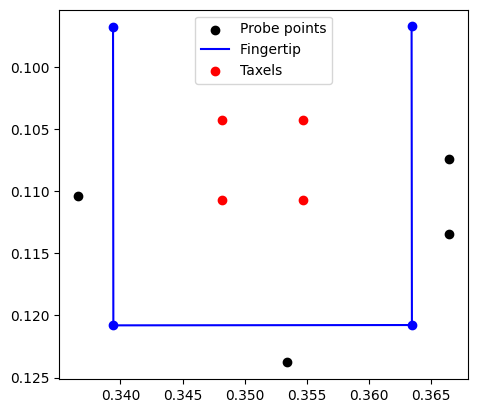

In [6]:
from tools.helpers import *
import matplotlib.pyplot as plt

tool_width = 0.006 / 2 # We want radius
pitch = 0.0065
# 7mm for my design, 6mm for remko design
# Offset should be the position of the first sensor, NOT the corner of the silicon
sensor_grid_size = (2, 2)
nr_of_subpoints = 0

grid_size = (sensor_grid_size[0] + (sensor_grid_size[0] - 1) * nr_of_subpoints, sensor_grid_size[1] + (sensor_grid_size[1] - 1) * nr_of_subpoints )

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
# width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Width x: {width_x}, width y: {0}")

#offset = ( (width_x - pitch * (sensor_grid_size[0] - 1)) / 2, 0.0068 - 0.003 + pitch / 2)  # (x, y) offset
offset = ( (width_x - pitch * (sensor_grid_size[0] - 1)) / 2, 0.0068 + pitch / 2)  # (x, y) offset


corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_x, tool_width)

# Corners index 0 and 3 are the bottom points
# So now we need to calculate the grid based on those

plt.scatter(poses[:, 0], poses[:, 1], c='black', label='Probe points')
plt.scatter(corners[:, 0], corners[:, 1], c='blue')

plt.plot([corners[-1, 0], corners[0, 0]], [corners[-1, 1], corners[0,1]], c='blue', label='Fingertip ')
plt.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1,1]], c='blue')
plt.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2,1]], c='blue')

grid = calculate_grid_on_square(corners, offset, grid_size, pitch / (nr_of_subpoints + 1))

# Add startpoint index 2,3,4,5 to grid
actual_grid = np.zeros((grid_size[1], grid_size[0], 6))
actual_grid[:, :, 2:] = start_point[2:]
actual_grid[:, :, :2] = grid

grid = actual_grid

plt.scatter(grid[:, :, 0], grid[:, :, 1], c='red', label='Taxels')

plt.xlabel
plt.legend()

plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

In [7]:
grid_reordered = grid.copy()
grid_reordered[0, 0] = grid[1, 1]
grid_reordered[0, 1] = grid[1, 0]
grid_reordered[1, 0] = grid[0, 0]
grid_reordered[1, 1] = grid[0, 1]
grid = grid_reordered

In [8]:
# Check if ok
import time
z_clearance = 0.002
duration = 5

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        
        time.sleep(duration / (grid_size[0] * grid_size[1]))
        controller.move_absolute(start_point[0:3])
  
controller.move_absolute(start_point[0:3])

[0.3533952919440873,
 0.11042921925592364,
 -0.06440949098439848,
 -1.2025355707536038,
 -2.902001751081378,
 0.0009682384154930706]

In [9]:
import time
from tools.measuring import MeasuringInterface
measuring_interface = MeasuringInterface(controller)

In [10]:
measuring_interface.start_measuring("tmp")
time.sleep(1)
measuring_interface.stop_measuring()

In [11]:
def ascending_sine_wave(time, frequency, max_amplitude, phase_shift = 0, shifted=True):
    max_time = np.max(time)
    time_adjusted = time - max_time
    if shifted:
        y_values = max_amplitude / max_time / 2 * time * (np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift) + 1)
    else:
        y_values = max_amplitude / max_time * time * np.sin(2 * np.pi * frequency * time_adjusted - np.pi/2 + phase_shift)
        
    return y_values[::-1]



In [12]:
from time import sleep

def apply_general_force(input_curves, sample_rate=200):
  
  limits = [0.1, 0.1, 0.1]
  
  points_x = input_curves[0]
  points_y = input_curves[1]  
  points_z = input_curves[2]
  
  assert len(points_x) == len(points_y) == len(points_z)
  
  for i in range(len(input_curves[0])):
    
    f_x = points_x[i]
    f_y = points_y[i]
    f_z = points_z[i]
    
    controller.force_mode([1, 1, 1], [f_x, f_y, f_z], limits)
    sleep(1 / sample_rate)

  

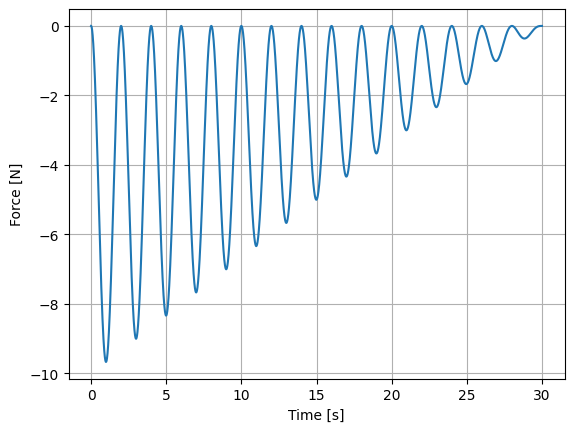

In [13]:
import matplotlib.pyplot as plt


def generate_forces(frequency, max_force, length, sample_rate=200):
  force_rate = abs(max_force) / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  normal_force_values = ascending_sine_wave(time, frequency, max_force, 0, True)
  
  return normal_force_values

for freq in [0.5]:
  normal_force_values = generate_forces(freq, -10, 30)
  time = np.linspace(0, 30, len(normal_force_values))
  plt.plot(time,normal_force_values)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.savefig("./result.png", bbox_inches='tight', format='png', dpi=1000)


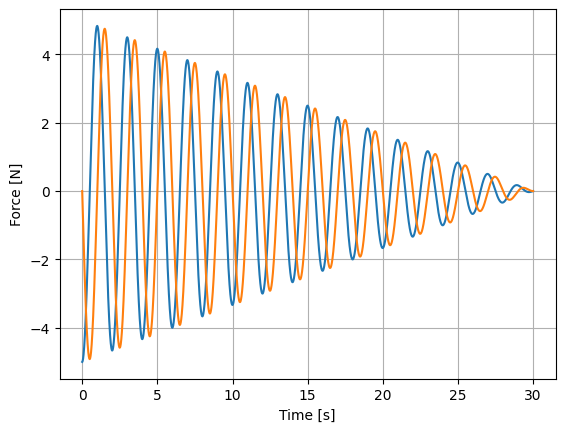

In [14]:
import numpy as np
def generate_xy_forces(frequency, max_force, length, sample_rate=200):
  force_rate = max_force / length

  time = np.linspace(0, abs(max_force) / force_rate, int(abs(max_force) / force_rate * sample_rate))  # Time values from 0 to 2 seconds

  x_force_values = ascending_sine_wave(time, frequency, max_force, 0, False)
  y_force_values = ascending_sine_wave(time, frequency, max_force, np.pi/2, False)
  
  return x_force_values, y_force_values, time

x_force_values, y_force_values, time = generate_xy_forces(0.5, 5, 30)

plt.plot(time, x_force_values)
plt.plot(time, y_force_values)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.savefig("./result.png", bbox_inches='tight', format='png', dpi=1000)

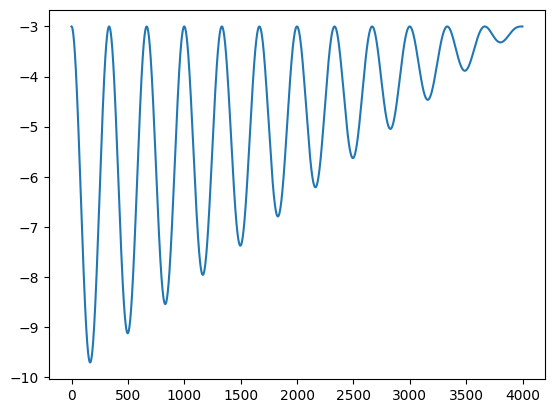

In [15]:
sample_rate=200
max_zforce = -10
max_xyforce = 10
length = 20
force_rate = abs(max_zforce) / length
time = np.linspace(0, abs(max_xyforce) / force_rate, int(abs(max_xyforce) / force_rate * sample_rate))  # Time values from 0 to 2 seconds
normal_force = ascending_sine_wave(time, freq*1.2, max_zforce + 3, 0, True) - 3
plt.plot(normal_force)

In [16]:
def calibrate_taxel(taxel_id, point, clearance, sample_rate=200):
  
  controller.move_absolute(point)
  rtde_c.zeroFtSensor()

  measuring_interface.start_measuring(f"remko5_003_taxel{taxel_id}")
  sleep(3)      
  
  for freq in [0.5]:
    max_zforce = -10
    length = 20
    force_rate = abs(max_zforce) / length
    time = np.linspace(0, abs(max_zforce) / force_rate, int(abs(max_zforce) / force_rate * sample_rate))  # Time values from 0 to 2 seconds
    
    #
    # Z component
    #
    
    normal_force_values = ascending_sine_wave(time, freq, max_zforce, 0, True)
    
    xy_force = np.zeros_like(normal_force_values)

    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([xy_force, xy_force, normal_force_values], 200)
    
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # X component
    #
    
    max_xyforce = 8
    length = 20
    force_rate = abs(max_xyforce) / length
    
    time = np.linspace(0, abs(max_xyforce) / force_rate, int(abs(max_xyforce) / force_rate * sample_rate))  # Time values from 0 to 2 seconds
    x_force = np.flip(ascending_sine_wave(time, freq, max_xyforce, 0, False))
    
    y_force = np.zeros_like(x_force)
    normal_force = np.ones_like(x_force) * -3
    
    # Zero prefix for the first 5 seconds
    x_force = np.concatenate([np.zeros(int(5 * sample_rate)), x_force])
    y_force = np.concatenate([np.zeros(int(5 * sample_rate)), y_force])
    normal_force = np.concatenate([np.ones(int(5 * sample_rate)) * -5, normal_force])

    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([x_force, y_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # Y component
    #
    
    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([y_force, x_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(point)
    
    sleep(3)
    
    #
    # XY component
    #
    max_xyforce = 6
    x_force = ascending_sine_wave(time, freq, max_xyforce, 0, False)
    y_force = ascending_sine_wave(time, freq, max_xyforce, np.pi/2, False)
    normal_force = ascending_sine_wave(time, freq*1.2, max_zforce + 3, 0, True) - 3
    
    # Zero prefix for the first 5 seconds
    x_force = np.concatenate([np.zeros(int(5 * sample_rate)), x_force])
    y_force = np.concatenate([np.zeros(int(5 * sample_rate)), y_force])    
    normal_force = np.concatenate([np.ones(int(5 * sample_rate)) * -5, normal_force])   
    
    controller.move_absolute(point)
    rtde_c.zeroFtSensor()
    sleep(1)
    
    controller.move_relative([0,0,-1 * clearance], 0.005)

    sleep(1)

    apply_general_force([y_force, x_force, normal_force], 200)
    
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(point)
    
    sleep(3)
    

  measuring_interface.stop_measuring()
  rtde_c.forceModeStop()
  controller.move_relative([0,0,0.01], 0.005)
  controller.move_absolute(start_point)

In [17]:
clearance = 0.9 * (start_point[2] - top_point_z)  # lower clearance, further from probe (unintuitive) 
print(clearance)

0.006686079939659953


In [18]:
idxs = [0,1,2,3]
skip = []

controller.move_absolute(start_point)

for i, idx in enumerate(idxs):
  
  print(f"Calibrating taxel {idx}")
  
  if idx in skip:
    print("Skipping taxel", idx)
    continue
  
  # Move to grid position
  controller.move_absolute(grid[i // 2][i % 2])
  controller.move_relative([0,0,-1 * clearance], 0.005)
  
  try:
      
    result = input("Confirm that the taxel is in the correct position: ")
    
    if result != "y":
      raise Exception("Taxel not in correct position")
    
    controller.move_relative([0,0,clearance], 0.005)
    

    calibrate_taxel(idx, grid[i // 2][i % 2], clearance)

  except Exception as e:
    print(e)
    print("Error on taxel", idx)
    
    measuring_interface.stop_measuring()
    rtde_c.forceModeStop()
    controller.move_relative([0,0,0.01], 0.005)
    controller.move_absolute(start_point)
    break

Calibrating taxel 0
Confirm that the taxel is in the correct position: y
Calibrating taxel 1
Confirm that the taxel is in the correct position: n
Taxel not in correct position
Error on taxel 1


RTDEReceiveInterface Exception: Operation canceled
RTDEControlInterface: Could not receive data from robot...
RTDEControlInterface Exception: Operation canceled
RTDEControlInterface: Robot is disconnected, reconnecting...


Reconnecting...
Dashboard client deadline expired


RTDEControlInterface Exception: Timeout connecting to UR dashboard server.


In [ ]:
measuring_interface.stop_measuring()
rtde_c.forceModeStop()
controller.move_relative([0,0,0.01], 0.005)
controller.move_absolute(start_point)

In [ ]:
controller.move_absolute(start_point)